# Classical geostatistics (geosclassic wrapper) - two-point statistics analysis of images

Two-point statistics analysis of image
- image of covariance, variogram, correlogram (correlation)
- geobody (connected component) image
- image of connectivity functions
- Gamma and Euler number connectivity indicator (curve)

**Remark:** examples in 2D are proposed here.

## Import what is required

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)
geone version: 1.1.11


### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Generate a continuous image and a binary image (2D)
To illustrate the image analysis tools, an initial continuous image (variable $v$) is generated (Gaussian Random Field, see jupyter notebook `ex_grf_2d`), and a binary image is obtained by considering the indicator variable $I(x)=1 \iff v(x)>0$, *i.e.* setting the value $1$ where the continuous variable is greater than $0$ and the value $0$ elsewhere.

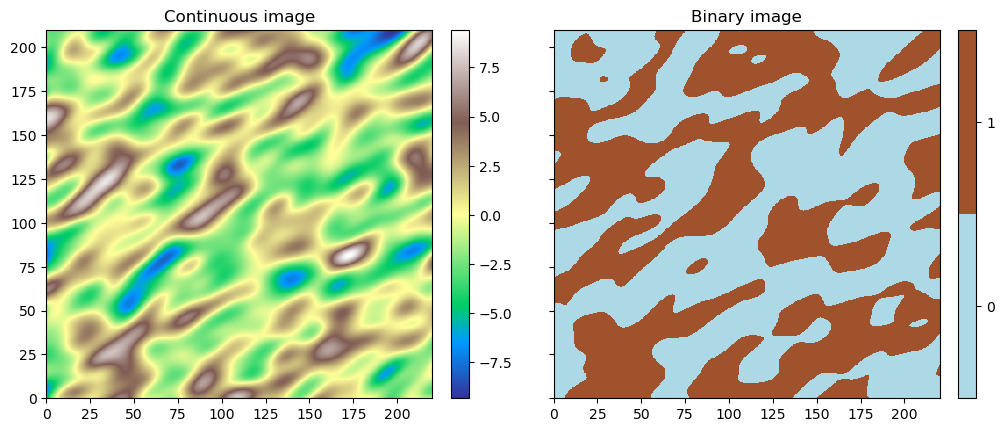

In [3]:
cov_model = gn.covModel.CovModel2D(elem=[
    ('gaussian', {'w':9, 'r':[30, 15]}),   # elementary contribution (different ranges: anisotropic)
    #('nugget', {'w':0.5})                   # elementary contribution
    ], alpha=-30.0, name='ref model (anisotropic)')

# Simulation grid (domain)
nx, ny = 440, 420  # number of cells
dx, dy = 0.5, 0.5  # cell unit
ox, oy = 0.0, 0.0  # origin

# Simulation
np.random.seed(222)
v = gn.grf.grf2D(cov_model, (nx, ny), (dx, dy), (ox, oy), nreal=1) 
    # 3d-array of shape 1 x ny x nx

# Define image containing the simulation
im_cont = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=v) # fill image (Img class from geone.img)

# Define the binary image
im_bin = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=(v>0))

# Display images 
col_bin = ['lightblue', 'sienna']
plt.subplots(1,2,figsize=(12,8), sharey=True)

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im_cont, cmap='terrain', title='Continuous image')

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_bin, categ=True, categVal=[0,1], categCol=col_bin, title='Binary image')

plt.show()

## Basic two-point statistics
### Function `geone.geosclassicinterface.imgTwoPointStatisticsImage`
The function `geone.geosclassicinterface.imgTwoPointStatisticsImage` allows to compute different types of two-point statistics for a variable $v$ in an input image and produces an output image of the chosen statistics for lag $h$ covering a grid, The following types of two-point statistics are available and passed to the function through the keyword argument `stat_type` (string):
- $\operatorname{cor}(v(x), v(x+h))$: Pearson correlation, `stat_type='correlogram'`
- $\operatorname{cov}(v(x), v(x+h))$: covariance, `stat_type='covariance'` (default)
- $\mathbb{E}(v(x)\cdot v(x+h))$: covariance not centered, `stat_type='covariance_not_centered'`
- $\mathbb{P}(v(x+h)>0 \vert v(x)>0)$: transiogram, `stat_type='transiogram'`
- $1/2\cdot\mathbb{E}\left((v(x)-v(x+h)^2\right)$: variogram, `stat_type='variogram'`

Note that a transiogram is computed for the indicator variable $I(x)$ defined as $I(x)=1 \iff v(x)>0$ (the binary image).

The minimal lag, maximal lag and the lag step in each direction are expressed in **number of cells** (in the input image minimal) and passed to the function with the keyword arguments `hx_min`, `hx_max`, `hx_step` (resp. `hy_min`, `hy_max`, `hy_step` and `hz_min`, `hz_max`, `hz_step`) for the $x$-axis direction (resp. for the $y$ and $z$-axis directions). For example, `hx_min=-10, hx_max=10, hx_step=2` implies that lags in $x$-axis direction of -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10 cells (in input image) will be considered. 

By default, the minimal and maximal lags are set to $\pm$ one half of the number of cells in the corresponding direction, and the lag step is set to 1.

The variable $v$ (in input image) of index `var_index` (keyword argument, default: `0`) is considered. 

This function launches a C program running in parallel (based on *OpenMP*). The number of threads used can be specified by the optional parameter (keyword argument) `nthreads`. Specifying for this parameter a number -n, negative or zero, means that the total number of cpus of the system (retrieved by os.cpu_count()) except n (but at least one) will be used. By default: `nthreads=-1`.

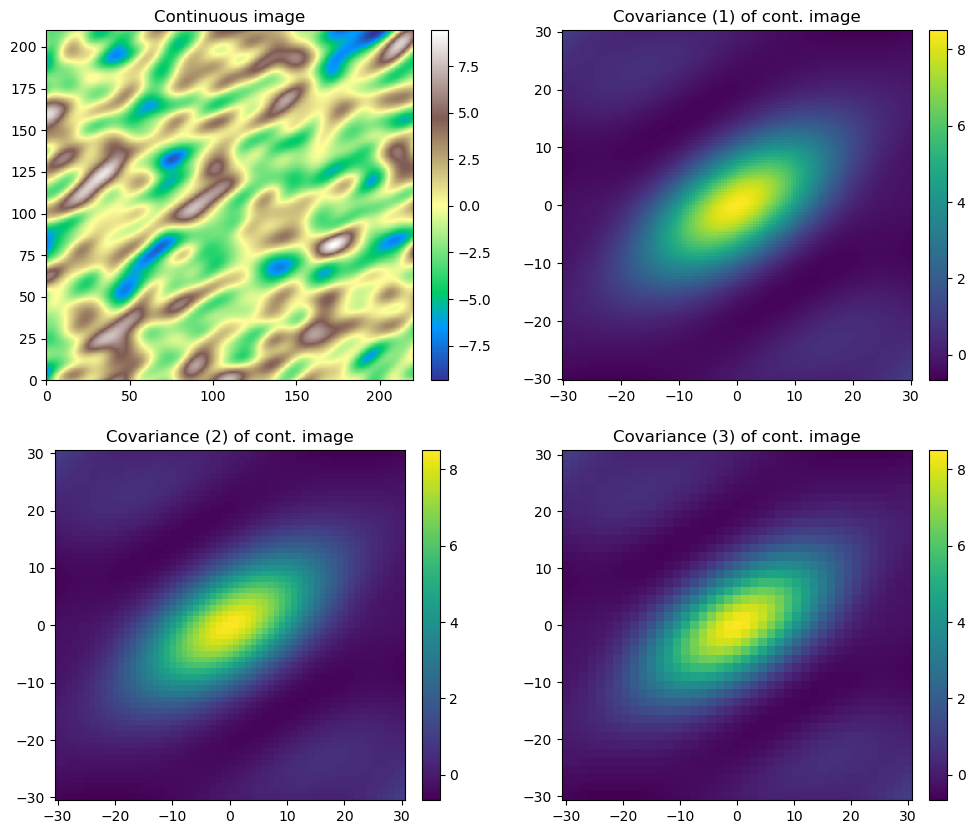

In [4]:
# For the continuous image:
# compute covariance map with different resolutions
im_cont_cov_1 = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_cont,
                                                                   hx_min=-60, hx_max=60, #hx_step=1,
                                                                   hy_min=-60, hy_max=60, #hy_step=1,
                                                                   #hz_min=0,   hz_max=0,  hz_step=1
                                                                   #nthreads=-1
                                                                  )
im_cont_cov_2 = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_cont,
                                                                   hx_min=-60, hx_max=60, hx_step=2,
                                                                   hy_min=-60, hy_max=60, hy_step=2)
im_cont_cov_3 = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_cont,
                                                                   hx_min=-60, hx_max=60, hx_step=3,
                                                                   hy_min=-60, hy_max=60, hy_step=3)

# Display images 
plt.subplots(2,2,figsize=(12,10))

plt.subplot(2,2,1)
gn.imgplot.drawImage2D(im_cont, cmap='terrain', title='Continuous image')

plt.subplot(2,2,2)
gn.imgplot.drawImage2D(im_cont_cov_1, cmap='viridis', title='Covariance (1) of cont. image')

plt.subplot(2,2,3)
gn.imgplot.drawImage2D(im_cont_cov_2, cmap='viridis', title='Covariance (2) of cont. image')

plt.subplot(2,2,4)
gn.imgplot.drawImage2D(im_cont_cov_3, cmap='viridis', title='Covariance (3) of cont. image')

plt.show()

In [5]:
print('covariance map 1: {} x {}, cell size = {} x {}'.format(im_cont_cov_1.nx, im_cont_cov_1.ny, 
                                                              im_cont_cov_1.sx, im_cont_cov_1.sy))
print('covariance map 2: {} x {}, cell size = {} x {}'.format(im_cont_cov_2.nx, im_cont_cov_2.ny, 
                                                              im_cont_cov_2.sx, im_cont_cov_2.sy))
print('covariance map 3: {} x {}, cell size = {} x {}'.format(im_cont_cov_3.nx, im_cont_cov_3.ny, 
                                                              im_cont_cov_3.sx, im_cont_cov_3.sy))

covariance map 1: 121 x 121, cell size = 0.5 x 0.5
covariance map 2: 61 x 61, cell size = 1.0 x 1.0
covariance map 3: 41 x 41, cell size = 1.5 x 1.5


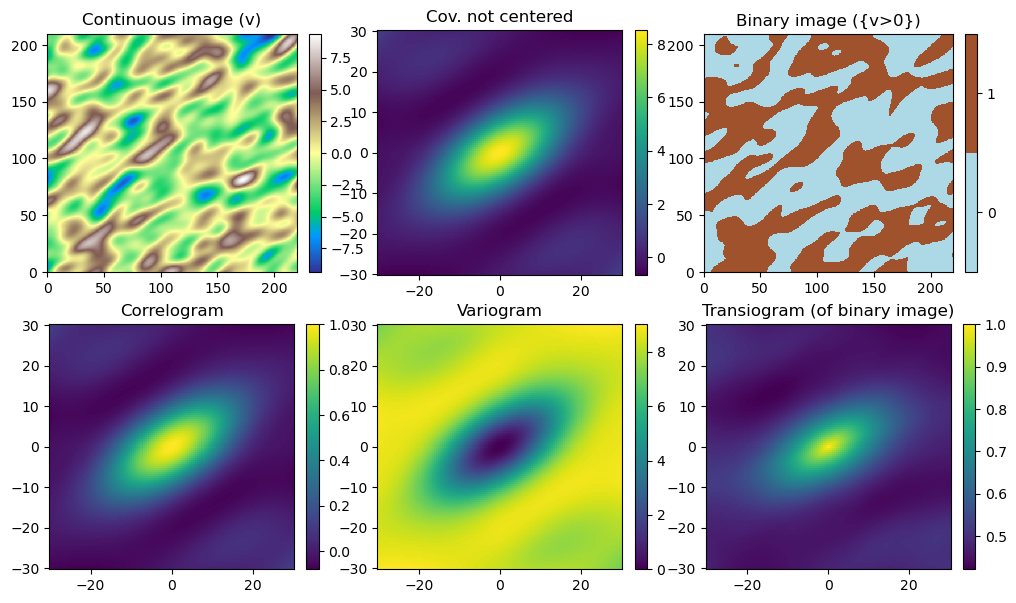

In [6]:
# Compute other two-point statistics
im_cont_cov_nc = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_cont,
                    hx_min=-60, hx_max=60, hy_min=-60, hy_max=60, stat_type='covariance_not_centered')
im_cont_cor = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_cont,
                    hx_min=-60, hx_max=60, hy_min=-60, hy_max=60, stat_type='correlogram')
im_cont_vario = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_cont,
                    hx_min=-60, hx_max=60, hy_min=-60, hy_max=60, stat_type='variogram')
im_bin_transio = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_bin, # (or im_cont)
                    hx_min=-60, hx_max=60, hy_min=-60, hy_max=60, stat_type='transiogram')

# Display images 
plt.subplots(2,3,figsize=(12,7))

plt.subplot(2,3,1)
gn.imgplot.drawImage2D(im_cont, cmap='terrain', title='Continuous image (v)')

plt.subplot(2,3,2)
gn.imgplot.drawImage2D(im_cont_cov_nc, cmap='viridis', title='Cov. not centered')

plt.subplot(2,3,3)
gn.imgplot.drawImage2D(im_bin, categ=True, categVal=[0,1], categCol=col_bin, title='Binary image ({v>0})')

plt.subplot(2,3,4)
gn.imgplot.drawImage2D(im_cont_cor, cmap='viridis', title='Correlogram')

plt.subplot(2,3,5)
gn.imgplot.drawImage2D(im_cont_vario, cmap='viridis', title='Variogram')

plt.subplot(2,3,6)
gn.imgplot.drawImage2D(im_bin_transio, cmap='viridis', title='Transiogram (of binary image)')

plt.show()

## Connectivity: geobody image
### Function `geone.geosclassicinterface.imgGeobodyImage`
The function `geone.geosclassicinterface.imgGeobodyImage` computes the geobody image (map) of a binary image. The output image has the same grid geometry as the input image and one variable consisting of the geobody label in the set $\{I=1\}$ from the input image (and value $0$ for cell in the set $\{I=0\}$).

The definition of adjacent cells depends on the keyword argument `connect_type` (string):
- `connect_type='connect_face'` (default): two grid cells are adjacent if they have a common face
- `connect_type='connect_face_edge'`: two grid cells are adjacent if they have a common face or a common edge
- `connect_type='connect_face_edge_corner'`: two grid cells are adjacent if they have a common face or a common edge or a common corner

A continuous image (variable $v$) can be given in input, it is then transformed into a binary image (variable $I$) according to the keyword argument `bound_inf` (default: $0$), `bound_sup` (default: "$+\infty$")(floats), and `bound_inf_excluded`, `bound_sup_excluded` (booleans): 
- $I(x) = 1 \iff$ `bound_inf` $< v(x) <$ `bound_sup` if `bound_inf_excluded` is `True` and `bound_sup_excluded` is `True` (default)
- $I(x) = 1 \iff$ `bound_inf` $< v(x) \leqslant$ `bound_sup` if `bound_inf_excluded` is `True` and `bound_sup_excluded` is `False`
- $I(x) = 1 \iff$ `bound_inf` $\leqslant v(x) <$ `bound_sup` if `bound_inf_excluded` is `False` and `bound_sup_excluded` is `True`
- $I(x) = 1 \iff$ `bound_inf` $\leqslant v(x) \leqslant$ `bound_sup` if `bound_inf_excluded` is `False` and `bound_sup_excluded` is `False`

Moreover, the keyword argument `complementary_set` (boolean) indicates that the variable $I_c(x) = 1-I(x)$ is used instead $I$ if `True`, *i.e.* the complementary binary image is considered. Default: `False` (variable $I$ is considered).

The variable $v$ (in input image) of index `var_index` (keyword argument, default: `0`) is considered. 

This function launches a C program (running in serial).

The algorithm used is described in *Hoshen and Kopelman (1976) Physical Review B, 14(8):3438*.

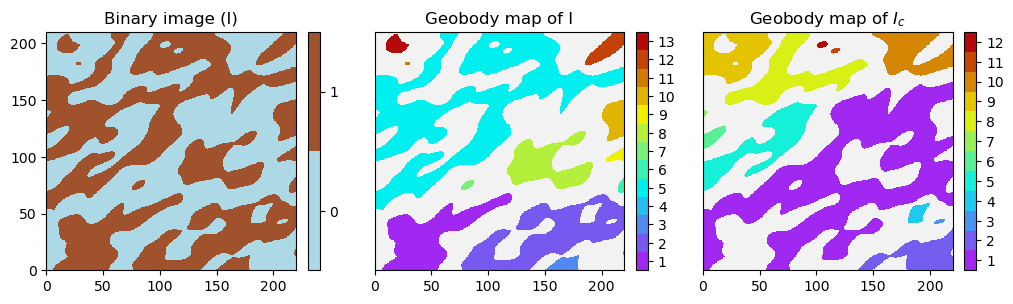

In [7]:
# Compute geobody map of the binary image
im_bin_geo = gn.geosclassicinterface.imgGeobodyImage(im_bin)
im_bin_c_geo = gn.geosclassicinterface.imgGeobodyImage(im_bin, complementary_set=True)

# Display images 
plt.subplots(1,3,figsize=(12,8))

plt.subplot(1,3,1)
gn.imgplot.drawImage2D(im_bin, categ=True, categVal=[0,1], categCol=col_bin, title='Binary image (I)')

plt.subplot(1,3,2)
gn.imgplot.drawImage2D(im_bin_geo, categ=True, categVal=np.arange(1,im_bin_geo.val.max()+1), 
                       yticks=[], title='Geobody map of I')
# value 0 not included in categVal so that it is not displayed

plt.subplot(1,3,3)
gn.imgplot.drawImage2D(im_bin_c_geo, categ=True, categVal=np.arange(1,im_bin_c_geo.val.max()+1), 
                       yticks=[], title='Geobody map of $I_c$')

plt.show()

## Connectivity analysis: ''connectogram''
### Function `geone.geosclassicinterface.imgTwoPointStatisticsImage`
The function `geone.geosclassicinterface.imgTwoPointStatisticsImage` also allows to compute probability of connection between two pairs of points as function as the lag between their locations.

The input image must be the geobody image of the underlying indicator variable I considered (computed using the function `geone.geosclassicinterface.imgGeobodyImage`). Let $C$ be the variable given the geobody label (equals to 0 if in no geobody), and 
let write $x\leftrightarrow y$ if the cells located at $x$ and $y$ are connected, *i.e.* in the same geobody.
Three connectivity function can be computed and specified by the keyword argument `stat_type` (string):
- $\mathbb{P}(x\leftrightarrow x+h) = \mathbb{P}(C(x) = C(x+h) > 0)$: `stat_type='connectivity_func0'`
- $\mathbb{P}(x\leftrightarrow x+h|I(x)=1) = \mathbb{P}(C(x) = C(x+h)|C(x) > 0)$: `stat_type='connectivity_func1'`
- $\mathbb{P}(x\leftrightarrow x+h|I(x)=I(x+h)=1) = \mathbb{P}(C(x) = C(x+h) > 0|C(x), C(x+h) > 0)$: `stat_type='connectivity_func2'`

In particular, we have the following relation:
$$\mathbb{P}(x \leftrightarrow x+h) = \mathbb{P}(x \leftrightarrow  x+h | I(x)=I(x+h)=1)\cdot\mathbb{E}(I(x)\cdot I(x+h))$$
*i.e* "connectivity_func0 = connectivity_func2 * covariance_not_centered".


See reference: *Renard P, Allard D (2013), Connectivity metrics for subsurface flow and transport. Adv Water Resour 51:168–196, [doi:10.1016/j.advwatres.2011.12.001](https://dx.doi.org/10.1016/j.advwatres.2011.12.001).*

The minimal lag, maximal lag and the lag step in each direction are expressed in **number of cells** and specified as explained above. The variable $v$ (in input image) of index `var_index` (keyword argument, default: `0`) is considered. This function launches a C program running in parallel, the number of threads used (keyword argument `nthreads`, see above) can be specified.

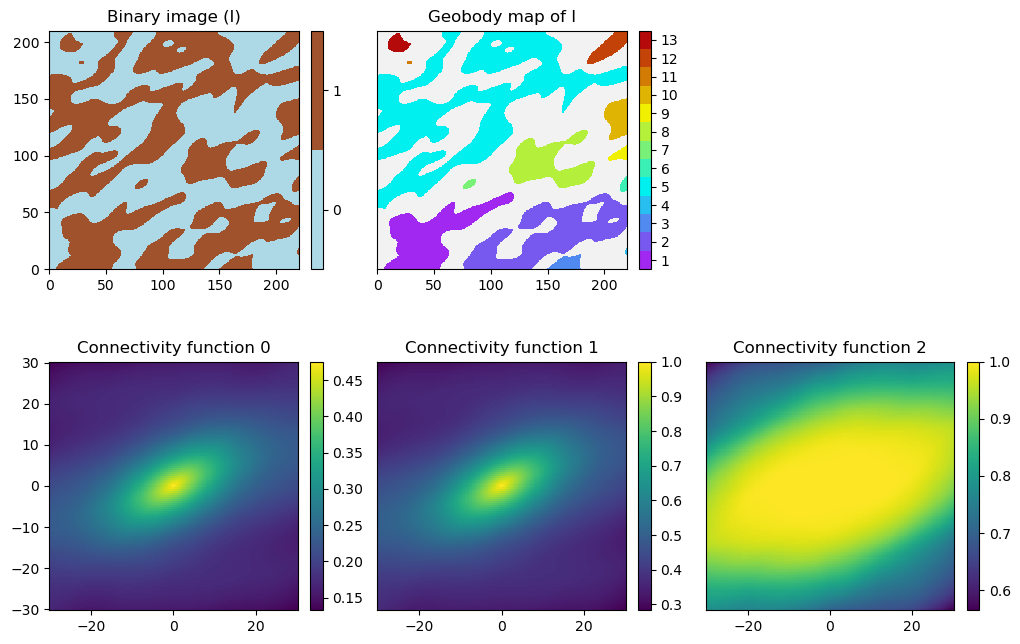

In [8]:
# Compute connectivity functions for the binary image im_bin
im_bin_geo = gn.geosclassicinterface.imgGeobodyImage(im_bin) # geobody image (already computed)

im_bin_connect0 = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_bin_geo,
                    hx_min=-60, hx_max=60, hy_min=-60, hy_max=60, stat_type='connectivity_func0')
im_bin_connect1 = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_bin_geo,
                    hx_min=-60, hx_max=60, hy_min=-60, hy_max=60, stat_type='connectivity_func1')
im_bin_connect2 = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_bin_geo,
                    hx_min=-60, hx_max=60, hy_min=-60, hy_max=60, stat_type='connectivity_func2')

# Display images 
plt.subplots(2,3,figsize=(12,8))

plt.subplot(2,3,1)
gn.imgplot.drawImage2D(im_bin, categ=True, categVal=[0,1], categCol=col_bin, title='Binary image (I)')

plt.subplot(2,3,2)
gn.imgplot.drawImage2D(im_bin_geo, categ=True, categVal=np.arange(1,im_bin_geo.val.max()+1),
                       yticks=[], title='Geobody map of I')

plt.subplot(2,3,3)
plt.axis('off')

plt.subplot(2,3,4)
gn.imgplot.drawImage2D(im_bin_connect0, cmap='viridis', title='Connectivity function 0')

plt.subplot(2,3,5)
gn.imgplot.drawImage2D(im_bin_connect1, cmap='viridis', yticks=[], title='Connectivity function 1')

plt.subplot(2,3,6)
gn.imgplot.drawImage2D(im_bin_connect2, cmap='viridis', yticks=[], title='Connectivity function 2')

plt.show()

## Connectivity analysis: Gamma value and Euler number
The functions `geone.geosclassicinterface.imgConnectivityGammaValue` and `geone.geosclassicinterface.imgConnectivityEulerNumber` computes the Gamma value and the Euler number for a binary image (or for the indicator variable $I(x)= 1 \iff v(x) \neq 0$ of a continuous image with variable $v$).

### Gamma value
The Gamma value is a global measure of connectivity and is defined as 
$$\Gamma = \left(\sum_{i=1}^N n_i\right)^{-2} \cdot \sum_{i=1}^N n_i^2$$ 
where $N$ is the number of connected components (geobodies) of the set $\{I=1\}$ and $n(i)$ the number of cells in the $i$-th geobody (geobody of label $i$). Hence, $\Gamma$ is the probability that two cells (possibly the same ones) taken randomly in the set $\{I=1\}$ are connected.

### Euler number
The Euler number $E$ gives the number of connected components (geobodies) + the number of ''holes'' - the number of ''handles'' in the set $\{I=1\}$, and can be computed by the formula 
$$E = \sum_{i=1,...,N} (e0_i - e1_i + e2_i - e3_i),$$
where $N$ the number of connected component (geobodies) in the set {I=1} and 
- $e0_i$ is the number of vertices (element of dimension 0) in the $i$-th geobody
- $e1_i$ is the number of edges (element of dimension 1) in the $i$-th geobody
- $e2_i$ is the number of faces (element of dimension 2) in the $i$-th geobody
- $e3_i$ is the number of volumes (cells, element of dimension 3) in the $i$-th geobody

where vertices, edges, faces, and volumes of any grid cell (3D parallelepiped element) are considered.

See reference: *Renard P, Allard D (2013), Connectivity metrics for subsurface flow and transport. Adv Water Resour 51:168–196, [doi:10.1016/j.advwatres.2011.12.001](https://dx.doi.org/10.1016/j.advwatres.2011.12.001).*

#### Function `geone.geosclassicinterface.imgConnectivityGammaValue` and 
#### Function `geone.geosclassicinterface.imgConnectivityEulerNumber`
For the two functions `geone.geosclassicinterface.imgConnectivityGammaValue` and `geone.geosclassicinterface.imgConnectivityEulerNumber`, the geobody image can directly be passed as input image, in this case the keyword argument `geobody_image_in_input` (boolean) must be set to `True` (and the geobody image is not computed), by default `geobody_image_in_input=False` and the geobody image is first computed.

Note that only the Euler number relies on the defintion of adjacent cells of type `connect_type='connect_face'` (see above), and then if the geobody image is given in input this type of connectivity should have been used. For the Gamma value, any of the three types of connectivity `connect_type='connect_face'`, `connect_type='connect_face_edge'`, or `connect_type='connect_face_edge_corner'` can be used. The keyword argument `connect_type` is available for the function `geone.geosclassicinterface.imgConnectivityGammaValue` (but ignored if the geobody image is given in input), whereas it is not available for the function `geone.geosclassicinterface.imgConnectivityEulerNumber`.

For both functions, the complementary set can be considered by setting the keyword argument `complementary_set` to `True` (default: `False`).

The variable $v$ (in input image) of index `var_index` (keyword argument, default: `0`) is considered. 

These functions launches C programs, the number of threads used (keyword argument `nthreads`, see above) can be specified only for the function `geone.geosclassicinterface.imgConnectivityEulerNumber` (parallel C program).

In [9]:
# Compute gamma and Euler number for the binary image
gamma = gn.geosclassicinterface.imgConnectivityGammaValue(im_bin)
eul = gn.geosclassicinterface.imgConnectivityEulerNumber(im_bin)
# OR:
#gamma = gn.geosclassicinterface.imgConnectivityGammaValue(im_bin_geo, geobody_image_in_input=True)
#eul = gn.geosclassicinterface.imgConnectivityEulerNumber(im_bin_geo, geobody_image_in_input=True)

# Compute gamma and Euler number for the complementary image
gammaC = gn.geosclassicinterface.imgConnectivityGammaValue(im_bin, complementary_set=True)
eulC = gn.geosclassicinterface.imgConnectivityEulerNumber(im_bin, complementary_set=True)

print('Binary image       : Gamma = {}, Euler number = {}'.format(gamma, eul))
print('Complementary image: Gamma = {}, Euler number = {}'.format(gammaC, eulC))

Binary image       : Gamma = 0.3199255051059247, Euler number = 9
Complementary image: Gamma = 0.35651027007762665, Euler number = 8


## Connectivity analysis: Gamma and Euler number curves
Consider a continuous variable $v$ (continuous image) and for a threshold value $t$ the indicator variable defined as $I(t)(x) = 1 \iff v(x) \leqslant t$.

Then, the Gamma value and the Euler number can be computed for the indicator variable $I(t)$ and for the complementary variable $I_c(t) = 1 - I(t)$. By varying the threshold value $t$, one obtain the curve $\Gamma(t)$, $E(t)$ and $\Gamma_c(t)$, $E_c(t)$ (for $I(t)$ and $I_c(t)$ resp.).

The functions `geone.geosclassicinterface.imgConnectivityGammaCurves` and `geone.geosclassicinterface.imgConnectivityEulerNumberCurves` computes theses curves. The threshold values considered are determined by the keyword arguments `threshold_min`, `threshold_max` and `nthreshold`: nthreshold equidistant values are considered, from threshold_min to threshold_max (*i.e.* 
`numpy.linspace(threshold_min, threshold_max, nthreshold)`). By default, `threshold_min` (resp. `threshold_max`) is set to the minimal (resp. maximal) value of the variable $v$ minus (resp. plus) 1.0e-10, and `nthreshold` to $50$.

These functions return an array of shape (`nthreshold`, 3) with the threshold values in colunm of index 0, and the Gamma values and resp. Euler numbers for the variable $I$ in column of index 1 and for the variable $I_c$ in column of index 2.

The type of connectivity (keyword argument `connect_type`, see above) can be specified only for the function `geone.geosclassicinterface.imgConnectivityGammaCurves`.

Note that for both functions the input image must have only one variable. 

For both functions, the number of threads used (keyword argument `nthreads`, see above) can be specified.

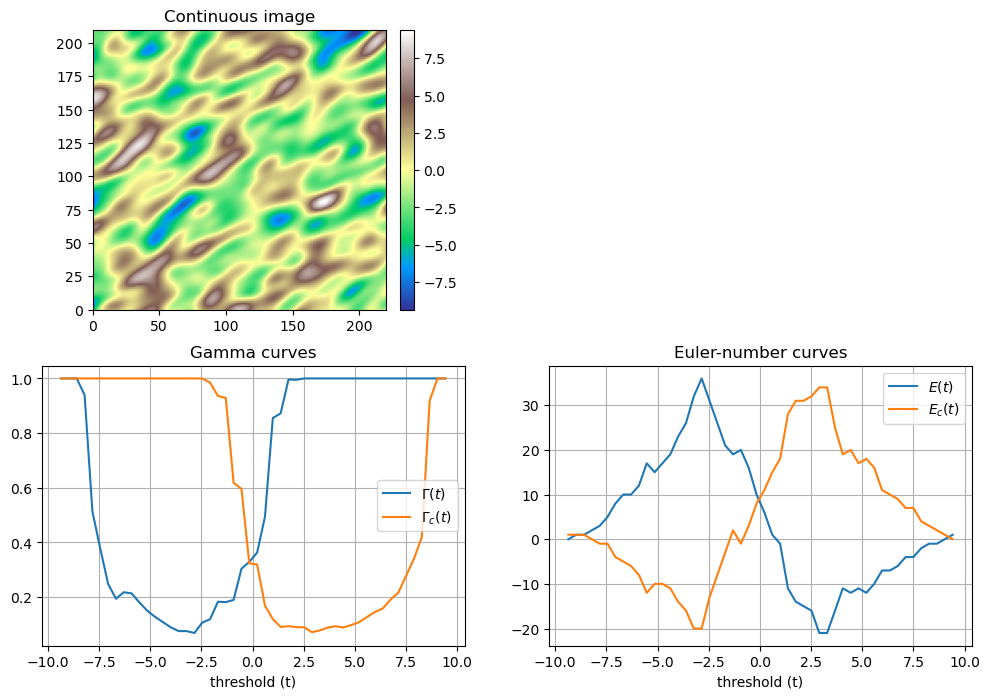

In [10]:
# Compute gamma and Euler-number curves for the continuous image
gammat = gn.geosclassicinterface.imgConnectivityGammaCurves(im_cont)
eult = gn.geosclassicinterface.imgConnectivityEulerNumberCurves(im_cont)

# Display
plt.subplots(2,2,figsize=(12,8))

plt.subplot(2,2,2)
plt.axis('off')

plt.subplot(2,2,1)
gn.imgplot.drawImage2D(im_cont, cmap='terrain', title='Continuous image')

plt.subplot(2,2,3)
plt.plot(gammat[:,0], gammat[:,1], label='$\Gamma(t)$')
plt.plot(gammat[:,0], gammat[:,2], label='$\Gamma_c(t)$')
plt.xlabel('threshold (t)')
plt.grid()
plt.legend()
plt.title('Gamma curves')

plt.subplot(2,2,4)
plt.plot(eult[:,0], eult[:,1], label='$E(t)$')
plt.plot(eult[:,0], eult[:,2], label='$E_c(t)$')
plt.xlabel('threshold (t)')
plt.grid()
plt.legend()
plt.title('Euler-number curves')

plt.show()

## Other tools: distance to binary media
The function `geone.geosclassicinterface.imgDistanceImage`computes the distance to the set $S = \{v\neq 0\}$, where $v$ is the variable of the input image, from every grid cell.

Distances $L_1$ and $L_2$ can be computed, this is specified by the keyword argument `distance_type` (string) which should be `L1` or `L2` (default). In addition, setting the keyword argument `distance_negative` to `True`, the distances (with a negative sign) from the interior cell of the set $S$ to its border are computed. By default, `distance_negative=False` (distance is zero for any cell in $S$).  

This function launches a C program running in parallel, the number of threads used (keyword argument `nthreads`, see above) can be specified.

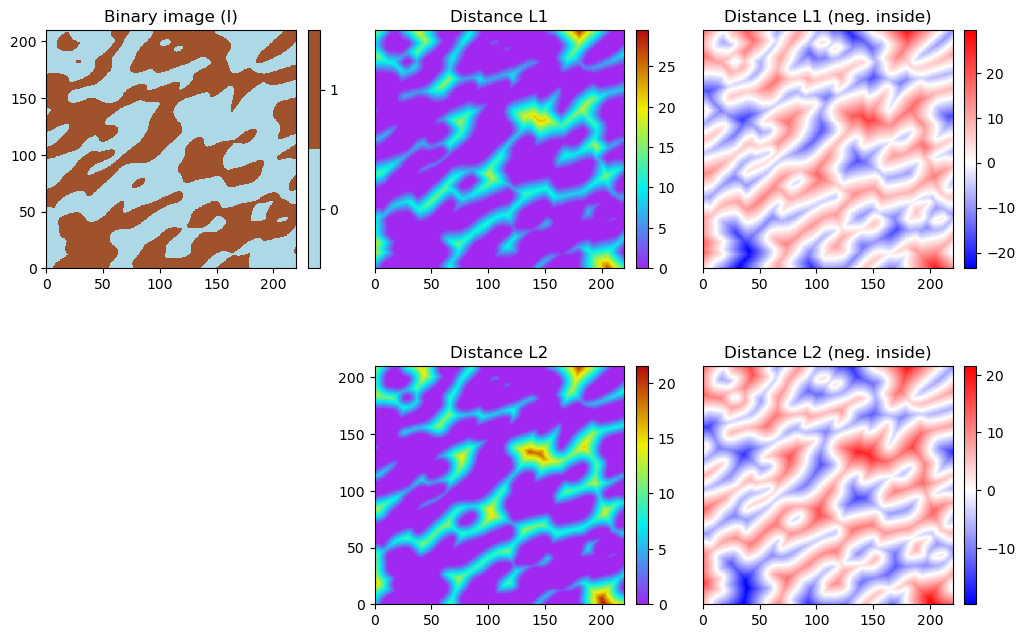

In [11]:
# Compute distance L1 for the binary image
im_bin_dist_L1   = gn.geosclassicinterface.imgDistanceImage(im_bin, distance_type='L1', distance_negative=False)
im_bin_dist_L1_n = gn.geosclassicinterface.imgDistanceImage(im_bin, distance_type='L1', distance_negative=True)

# Compute distance L2 for the binary image
im_bin_dist_L2   = gn.geosclassicinterface.imgDistanceImage(im_bin, distance_type='L2', distance_negative=False)
im_bin_dist_L2_n = gn.geosclassicinterface.imgDistanceImage(im_bin, distance_type='L2', distance_negative=True)

# Display images 
# Custom color map from blue (min) to white (value=0) to red (max)
# ... for im_bin_dist_L1_n
cmap1 = gn.customcolors.custom_cmap(
            ['blue', 'white', 'red'],
            vseq=[im_bin_dist_L1_n.val.min(), 0, im_bin_dist_L1_n.val.max()])
# ... for im_bin_dist_L2_n
cmap2 = gn.customcolors.custom_cmap(
            ['blue', 'white', 'red'],
            vseq=[im_bin_dist_L2_n.val.min(), 0, im_bin_dist_L2_n.val.max()])

plt.subplots(2,3,figsize=(12,8))

plt.subplot(2,3,1)
gn.imgplot.drawImage2D(im_bin, categ=True, categVal=[0,1], categCol=col_bin, title='Binary image (I)')

plt.subplot(2,3,2)
gn.imgplot.drawImage2D(im_bin_dist_L1, yticks=[], title='Distance L1')

plt.subplot(2,3,3)
gn.imgplot.drawImage2D(im_bin_dist_L1_n, cmap=cmap1, yticks=[], title='Distance L1 (neg. inside)')

plt.subplot(2,3,4)
plt.axis('off')

plt.subplot(2,3,5)
gn.imgplot.drawImage2D(im_bin_dist_L2, title='Distance L2')

plt.subplot(2,3,6)
gn.imgplot.drawImage2D(im_bin_dist_L2_n, cmap=cmap2, yticks=[], title='Distance L2 (neg. inside)')

plt.show()